In [1]:
#Required python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import re
import torch
import nltk
import nltk.data
from string import punctuation 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords

In [3]:
df_senti=pd.read_csv("../data/raw/sentiments_training.csv", encoding= 'unicode_escape')
df_test=pd.read_csv("../data/raw/sentiments_test.csv", encoding= 'unicode_escape')

In [4]:
df_senti.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [5]:
df_test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [6]:
df_senti.shape,df_test.shape

((27481, 10), (4815, 9))

In [7]:
print("Training set:",df_senti['sentiment'].value_counts())
print("Test set:",df_test['sentiment'].value_counts())

Training set: neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64
Test set: neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64


In [8]:
def text_cleaning(text):
   
    text = re.sub(r"[^A-Za-z]", " ", str(text))
    
     #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # Remove punctuation from text
    text = "".join([c for c in text if c not in punctuation])
    stopwords = nltk.corpus.stopwords.words('english')
    text = text.split()
    text = [w for w in text if not w in stopwords]
    text = " ".join(text)
        
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    text=text.lower()
    
    return text 

In [47]:
df_senti['cleaned_text'][5]

'http www dothebouncy com smf shameless plugging best rangers forum earth'

In [9]:
df_senti['cleaned_text'] = df_senti['text'].apply(lambda x: text_cleaning(x))
df_test['cleaned_text'] = df_test['text'].apply(lambda x: text_cleaning(x))

In [10]:
df_senti['number_words']=df_senti['cleaned_text'].str.split().apply(len)
df_test['number_words']=df_test['cleaned_text'].str.split().apply(len)

In [11]:
df_senti['number_words'].min(),df_senti['number_words'].max(), df_senti['number_words'].median()

(0, 28, 7.0)

In [12]:
df_test['number_words'].min(),df_test['number_words'].max(), df_test['number_words'].median()

(0, 30, 5.0)

In [13]:
df=df_senti[df_senti['number_words']>1]
df_test=df_test[df_test['number_words']>0]

print(df.shape)
print(df_test.shape)

(26850, 12)
(4806, 11)


In [14]:
print(df['sentiment'].value_counts())

neutral     10699
positive     8479
negative     7672
Name: sentiment, dtype: int64


In [15]:
df=df[['cleaned_text','sentiment']]

In [16]:
df=df.reset_index()
df

,index,cleaned_text,sentiment
0,0,i responded i going,neutral
1,1,sooo sad i miss san diego,negative
2,2,bos bullying,negative
3,3,interview leave alone,negative
4,4,sons put release already bought,negative
...,...,...,...
26845,27476,wish could come see u denver husband lost job ...,negative
26846,27477,i wondered rake the client made clear net forc...,negative
26847,27478,yay good enjoy break probably need hectic week...,positive
26848,27479,but worth,positive


In [17]:
df.to_csv("../data/processed/cleaned_text_forbert_sentiment.csv", index=False, header=False)

In [17]:
df['labels'] = df['sentiment'].factorize()[0]
df.head()

,index,cleaned_text,sentiment,labels
0,0,i responded i going,neutral,0
1,1,sooo sad i miss san diego,negative,1
2,2,bos bullying,negative,1
3,3,interview leave alone,negative,1
4,4,sons put release already bought,negative,1


In [18]:
uniquevalues = pd.unique(df[['sentiment']].values.ravel())
df_unique=pd.DataFrame(uniquevalues,columns=['sentiment'])
df_unique

,sentiment
0,neutral
1,negative
2,positive


In [19]:
df_test=df_test.dropna()
df_test

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),cleaned_text,number_words
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,last session day http twitpic com ezh,7
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0,shanghai also really exciting precisely skyscr...,12
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,recession hit veronique branquinho quit compan...,7
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0,happy bday,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0,http twitpic com w p i like,7
...,...,...,...,...,...,...,...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,noon,21-30,Nicaragua,6624554.0,120340.0,55.0,im tired sleep try,4
3530,416863ce47,All alone in this old house again. Thanks for...,positive,night,31-45,Niger,24206644.0,1266700.0,19.0,all alone old house thanks net keep alive kick...,15
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,morning,46-60,Nigeria,206139589.0,910770.0,226.0,i know mean my little dog sinking depression w...,12
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,noon,60-70,North Korea,25778816.0,120410.0,214.0,sutra next youtube video gonna i love video,8


In [20]:
df_test=df_test.reset_index()
df_test=df_test[['cleaned_text','sentiment']].copy()

In [21]:
mapp={'neutral':0,'negative':1,'positive':2}
df_test['labels']=df_test['sentiment'].map(mapp)

In [22]:
df_test

,cleaned_text,sentiment,labels
0,last session day http twitpic com ezh,neutral,0
1,shanghai also really exciting precisely skyscr...,positive,2
2,recession hit veronique branquinho quit compan...,negative,1
3,happy bday,positive,2
4,http twitpic com w p i like,positive,2
...,...,...,...
3520,im tired sleep try,negative,1
3521,all alone old house thanks net keep alive kick...,positive,2
3522,i know mean my little dog sinking depression w...,negative,1
3523,sutra next youtube video gonna i love video,positive,2


In [23]:
#importing libraries for models and nlp tasks
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sentence_transformers import SentenceTransformer


In [24]:
ytrain =df['labels']
ytest=df_test['labels']

In [28]:
Xtrain=df['cleaned_text']
Xtest=df_test['cleaned_text']

In [25]:
model = SentenceTransformer('all-MiniLM-L6-v2')


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [30]:
def sentence(text):
    return model.encode(text)
    

In [36]:
def bertembeddings(Xtrain,Xtest):
    Xtrain=Xtrain
    Xtest=Xtest
    
    with torch.no_grad():    


        train = Xtrain.apply(lambda x: sentence(x))
        test = Xtest.apply(lambda x: sentence(x))


    tf= [x for x in train.transpose()]
    train_features = np.asarray(tf)

    t= [x for x in test.transpose()]
    test_features = np.asarray(t)
    
    return train_features,test_features

In [37]:
train_embed,test_embed=bertembeddings(Xtrain,Xtest)

In [34]:
print(train_embed[0])

[ 2.75925379e-02 -3.77202332e-02  3.62994126e-03  2.83393506e-02
 -5.12852333e-03 -7.83601552e-02  8.49525332e-02  4.48062830e-02
 -2.06068344e-02 -1.40900034e-02 -5.24994917e-02 -8.15637410e-02
 -4.74934131e-02  6.75385073e-02  3.96818556e-02  2.09519044e-02
  4.42109369e-02 -9.44448262e-02 -1.20808460e-01 -5.52069163e-03
 -7.53235593e-02 -6.94265240e-04 -5.02348021e-02  5.60733825e-02
 -5.93579374e-02  2.23521162e-02 -1.85634531e-02  5.73833063e-02
  1.00166677e-02  1.97142977e-02 -8.10729116e-02  1.81256142e-02
 -4.55687381e-02  3.85190062e-02 -4.49471734e-02  8.82585943e-02
 -4.62960638e-03 -1.09590098e-01  6.17955551e-02  2.05418211e-03
  1.36114834e-02 -1.42946858e-02  4.42084335e-02  3.43574844e-02
  7.19881877e-02  6.50703860e-03  6.99381856e-03 -3.36058512e-02
  3.11211608e-02 -2.65769437e-02  6.18243124e-03 -8.35235510e-03
 -3.64929475e-02 -4.71998379e-03 -4.17555653e-04  3.56258526e-02
 -5.57568371e-02 -2.17526108e-02  4.62878533e-02 -1.43572772e-02
  7.19522685e-02 -2.90742

##### Logistic Regression model

In [38]:
#Logistic Regression with multinomial
lr_mn = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_mn.fit(train_embed, ytrain)

/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [39]:
ypred_lr_mn=lr_mn.predict(test_embed)

In [40]:
tr_acc_lr_mn = lr_mn.score(train_embed, ytrain)*100
test_acc_lr_mn =  accuracy_score(ytest,ypred_lr_mn) * 100
print(tr_acc_lr_mn,test_acc_lr_mn)

69.7243947858473 69.04964539007092


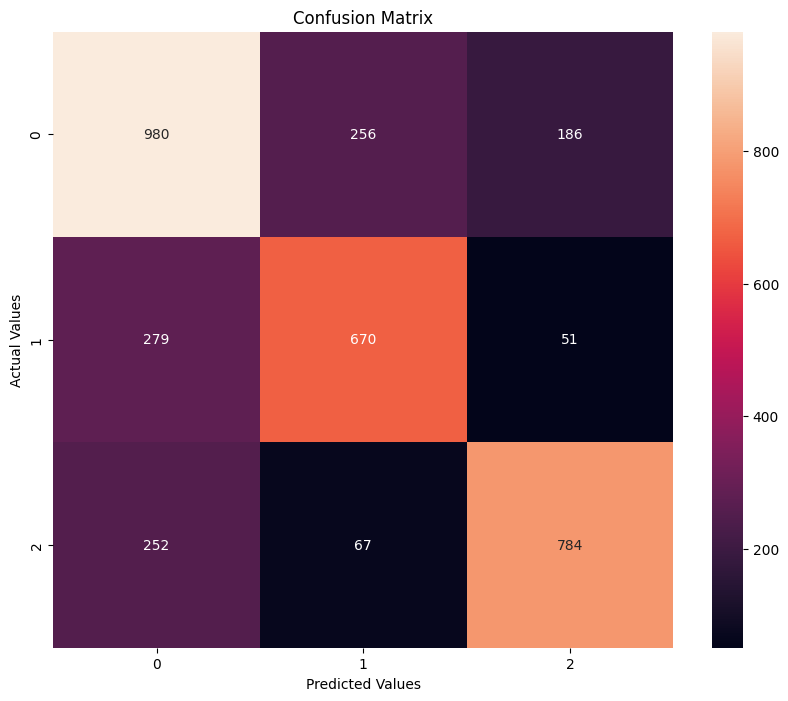

In [41]:
cm = confusion_matrix(ytest, ypred_lr_mn)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [42]:
pickle.dump(lr_mn, open('../models/lr_mn_sentiment_bert.pkl', 'wb'))

##### SVM Classifier

In [43]:
%%time
svm = SVC( kernel ='linear',C = 1, decision_function_shape='ovo')
svm.fit(train_embed, ytrain)

CPU times: user 2min 45s, sys: 1.46 s, total: 2min 47s
Wall time: 2min 47s


SVC(C=1, decision_function_shape='ovo', kernel='linear')

In [44]:
ypred_svm=svm.predict(test_embed)

In [45]:
tr_acc_svm= svm.score(train_embed, ytrain)*100
test_acc_svm =  accuracy_score(ytest,ypred_svm) * 100
print(tr_acc_svm,test_acc_svm)

69.81750465549348 68.9645390070922


In [46]:
pickle.dump(svm, open('../models/svm_sentiment_bert.pkl', 'wb'))